## setup


In [19]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML + Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             average_precision_score, precision_recall_curve,
                             precision_score, recall_score, f1_score)

from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")



## load and basic understanding


In [20]:
df = pd.read_csv("creditcard.csv")
print("Dataset Shape:", df.shape)
print("Class Distribution:\n", df['Class'].value_counts())
df.head()


Dataset Shape: (284807, 31)
Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## preprocessing missing values and duplicates


In [21]:
# Missing values
print("Missing values:\n", df.isnull().sum())

# Duplicate removal
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
df.drop_duplicates(inplace=True)


Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Duplicate rows: 1081


## outlier detection


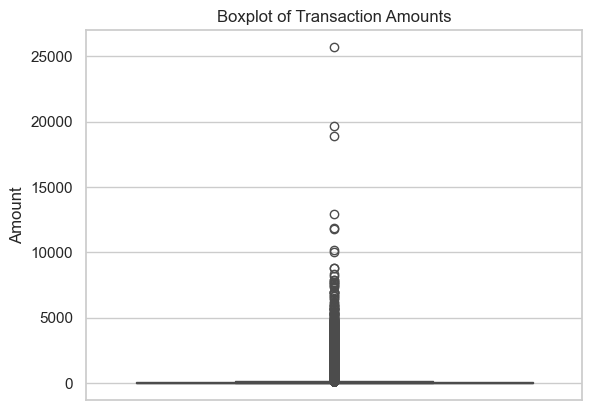

In [22]:
# Boxplot of 'Amount'
sns.boxplot(df['Amount'])
plt.title("Boxplot of Transaction Amounts")
plt.show()

# Optionally, remove extreme outliers (e.g. Amount > 5000)
df = df[df['Amount'] < 5000]


## feature scaling


In [23]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])


## feature engineering


In [24]:
# Hour feature from Time (already scaled, reverse first)
df['Hour'] = ((df['Time'] * scaler.scale_[0]) + scaler.mean_[0]) // 3600 % 24

# High Amount binary feature
df['IsHighAmount'] = df['Amount'].apply(lambda x: 1 if x > 2 else 0)


## feature selection


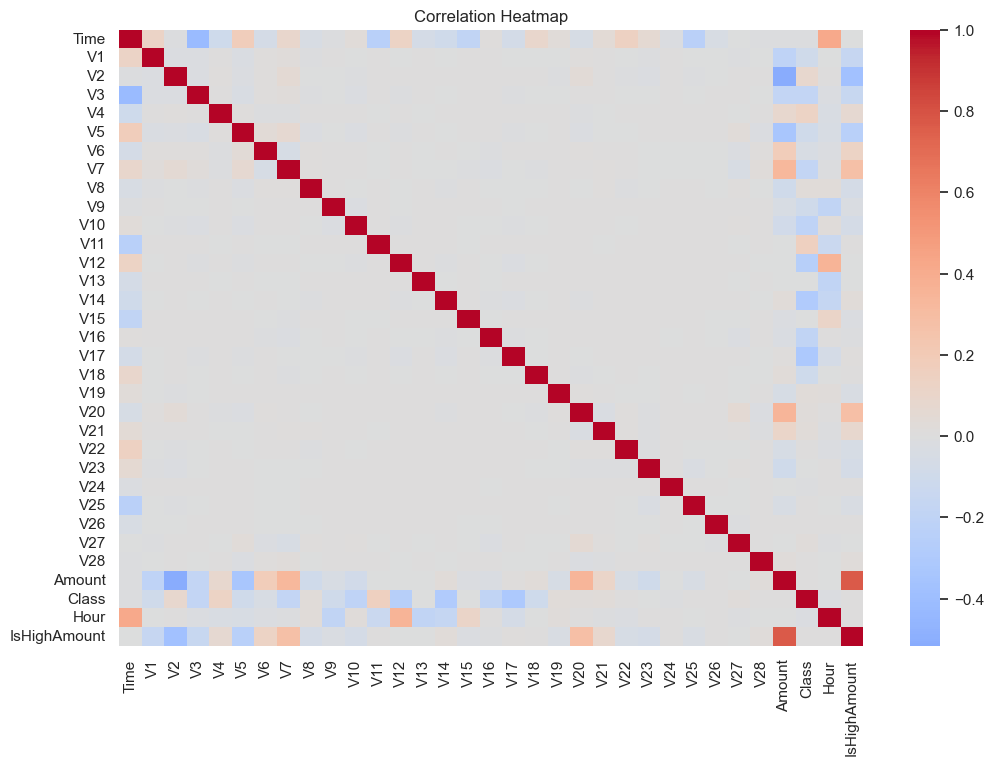

In [25]:
# Correlation matrix (top features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


## EDA fraud vs non-fraud(pie chart)


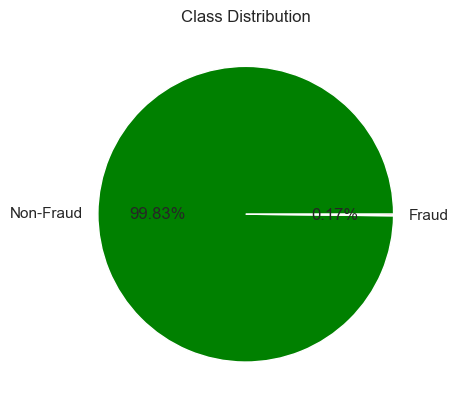

In [26]:
labels = ['Non-Fraud', 'Fraud']
sizes = df['Class'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=['green', 'red'])
plt.title("Class Distribution")
plt.show()


## histograms + boxplots + violin plots


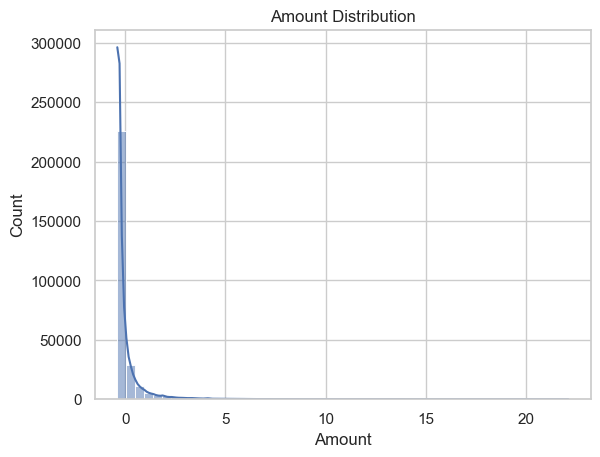

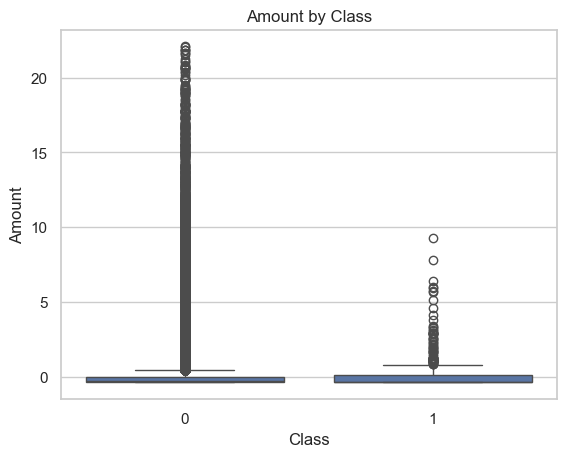

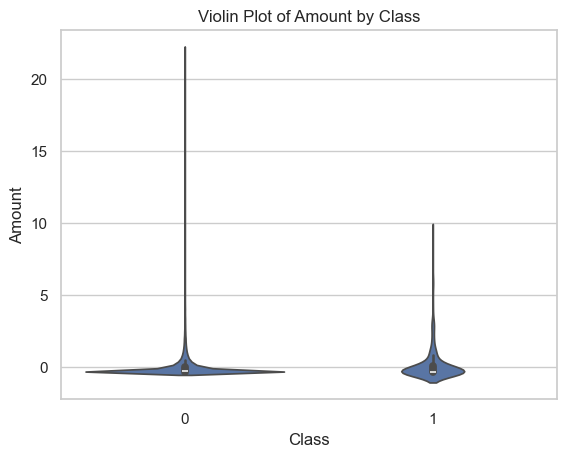

In [27]:
# Histogram
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Amount Distribution")
plt.show()

# Boxplot by Class
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Amount by Class")
plt.show()

# Violin Plot
sns.violinplot(x='Class', y='Amount', data=df)
plt.title("Violin Plot of Amount by Class")
plt.show()


## time vs fraud pattern


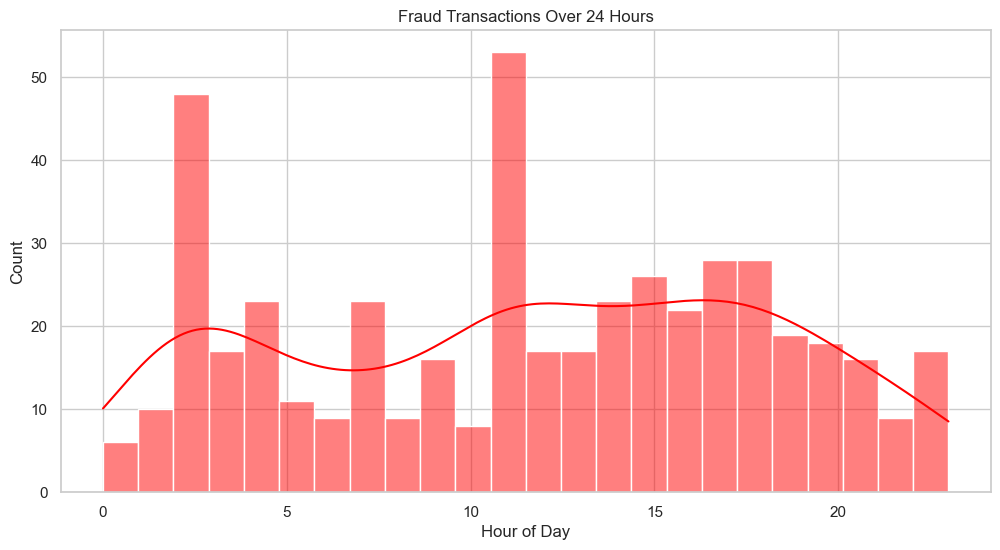

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['Class'] == 1], x='Hour', bins=24, color='red', kde=True)
plt.title("Fraud Transactions Over 24 Hours")
plt.xlabel("Hour of Day")
plt.show()


## reporting key insights


In [29]:
fraud_cases = df[df['Class'] == 1]
nonfraud_cases = df[df['Class'] == 0]

print(f"Total transactions: {len(df)}")
print(f"Fraud ratio: 1 fraud per ~{round(len(df)/len(fraud_cases))} transactions")
print(f"Mean Fraud Amount: {fraud_cases['Amount'].mean():.2f}")
print(f"Mean Non-Fraud Amount: {nonfraud_cases['Amount'].mean():.2f}")
print(f"Fraud peak hour (most cases): {fraud_cases['Hour'].mode()[0]}")


Total transactions: 283671
Fraud ratio: 1 fraud per ~600 transactions
Mean Fraud Amount: 0.17
Mean Non-Fraud Amount: -0.00
Fraud peak hour (most cases): 11.0


## statistical test


In [30]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(fraud_cases['Amount'], nonfraud_cases['Amount'])
print(f"Mann-Whitney U test p-value: {p:.5f}")
if p < 0.05:
    print("Statistically significant difference in Amount between fraud and non-fraud")


Mann-Whitney U test p-value: 0.00003
Statistically significant difference in Amount between fraud and non-fraud


## handling imbalance


In [31]:
X = df.drop(['Class'], axis=1)
y = df['Class']

# SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

print("After resampling:\n", pd.Series(y_resampled).value_counts())


After resampling:
 Class
0    283198
1    283198
Name: count, dtype: int64


## train-test split


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


## hybrid model (xgboost + cnn-lstm)


In [33]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities


In [34]:
# Reshape for CNN-LSTM
X_train_seq = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_seq = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

cnn_lstm = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm.fit(X_train_seq, y_train, epochs=5, batch_size=512, validation_split=0.2)

cnn_preds = cnn_lstm.predict(X_test_seq).flatten()


Epoch 1/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.9357 - loss: 0.1658 - val_accuracy: 0.9618 - val_loss: 0.0923
Epoch 2/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9745 - loss: 0.0648 - val_accuracy: 0.9824 - val_loss: 0.0443
Epoch 3/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9841 - loss: 0.0421 - val_accuracy: 0.9894 - val_loss: 0.0291
Epoch 4/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9897 - loss: 0.0292 - val_accuracy: 0.9911 - val_loss: 0.0269
Epoch 5/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9930 - loss: 0.0211 - val_accuracy: 0.9926 - val_loss: 0.0205
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


## Combined Hybrid Prediction (XGBoost + CNN-LSTM)


In [35]:
# Weighted Hybrid Prediction
hybrid_preds = (xgb_preds * 0.3) + (cnn_preds * 0.7)
hybrid_class = (hybrid_preds > 0.5).astype(int)


## Evaluation – PR AUC


In [36]:
def evaluate(name, y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)
    
    print(f"\n{name} Evaluation")
    print(f"PR-AUC Score: {pr_auc:.4f}")
    print(f"F1 Score: {f1_score(y_true, (y_scores>0.5).astype(int)):.4f}")
    print(f"Precision: {precision_score(y_true, (y_scores>0.5).astype(int)):.4f}")
    print(f"Recall: {recall_score(y_true, (y_scores>0.5).astype(int)):.4f}")
    
    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, (y_scores>0.5).astype(int)))
    
    # Plot PR curve
    plt.plot(recall, precision, label=f'{name} (PR AUC={pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


## Evaluate All Models



XGBoost Evaluation
PR-AUC Score: 1.0000
F1 Score: 0.9999
Precision: 0.9997
Recall: 1.0000
Confusion Matrix:
[[56624    16]
 [    0 56640]]


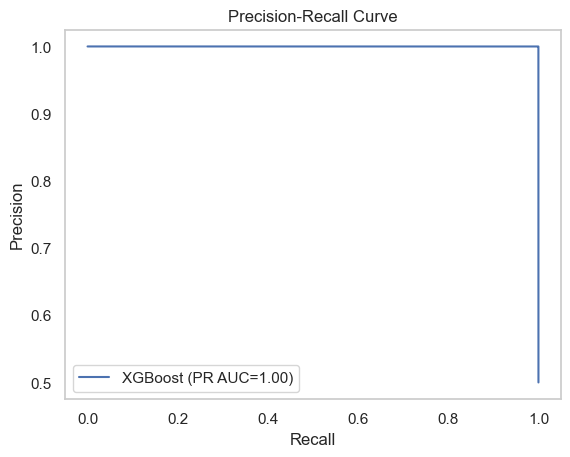


CNN-LSTM Evaluation
PR-AUC Score: 0.9997
F1 Score: 0.9927
Precision: 0.9864
Recall: 0.9991
Confusion Matrix:
[[55858   782]
 [   49 56591]]


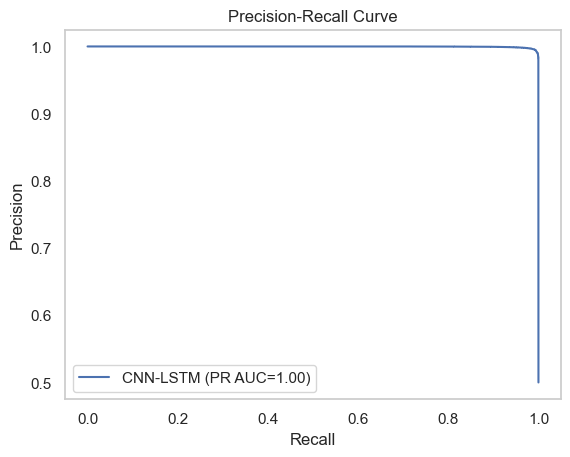


Hybrid (XGB + CNN-LSTM) Evaluation
PR-AUC Score: 1.0000
F1 Score: 0.9948
Precision: 0.9898
Recall: 0.9998
Confusion Matrix:
[[56058   582]
 [   13 56627]]


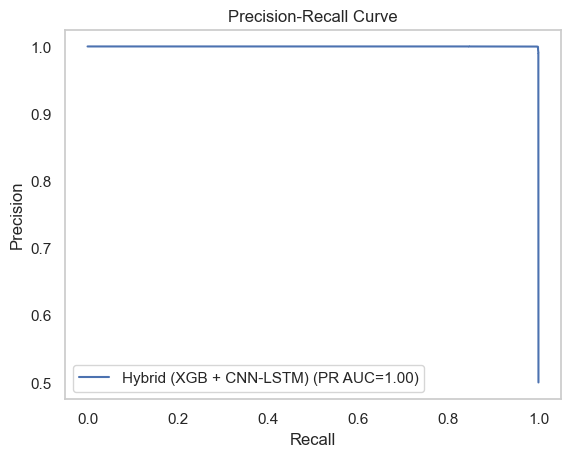

In [37]:
evaluate("XGBoost", y_test, xgb_preds)
evaluate("CNN-LSTM", y_test, cnn_preds)
evaluate("Hybrid (XGB + CNN-LSTM)", y_test, hybrid_preds)
